In [1]:
from huggingface_hub import login
hf_token = ''
login(hf_token)

C:\Users\jc\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\jc\.cache\huggingface\token
Login successful


In [48]:
import torch
import pickle
import spacy
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset

In [3]:
BASE_MODEL = "jucargoe/fine-tuned-llama-3"

In [4]:
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
nlp = spacy.load('en_core_web_md')

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


In [5]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto"
)

In [6]:
def calculate_context_of_sentence_in_corpus(corpus_vec, sentence):
    query = nlp(sentence)
    q_vec = query.vector
    return cosine_similarity([corpus_vec], [q_vec])

def transform_sentence(sentence):
    sentence_transformed = []
    nlp_sentence = nlp(sentence)
    
    for word in nlp_sentence:
        if not word.is_stop and not word.is_punct and not word.like_num:
            sentence_transformed.append(word.text)

    return ' '.join(sentence_transformed)
    
def inference(user_input):
    with open('sentences_vector_processed.pickle', 'rb') as file:
        corpus_vec = pickle.load(file)
    
    context = calculate_context_of_sentence_in_corpus(corpus_vec, transform_sentence(user_input))
    if context > 0.55:
        prompt = f"""
You are a powerful text-to-Python model.
Your job is to answer questions about a Python.
You are given a question regarding Python code.
You must output the Python code that answers the question tabulated correctly.
Only one response was allowed.
### Input:
{user_input}

### Response:
        """
        output = pipe(
            prompt,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.95
        )
        output = output[0]['generated_text'].split('### Response:')
        if len(output) > 1:
            output = output[1]
            if '###' in output:
                output = output.split('###')[0]
            
            output = output.replace('```python', '')
            output = output.replace('```', '')
    else:
        output = 'ERROR: The sentence you have entered is not related with Python code generation, please write a new sentence.'
    
    return output

In [38]:
dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split="train")
# train_dataset = dataset.train_test_split(test_size=0.2)["train"]
# eval_dataset = dataset.train_test_split(test_size=0.2)["test"]

Using the latest cached version of the dataset since iamtarun/python_code_instructions_18k_alpaca couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\jc\.cache\huggingface\datasets\iamtarun___python_code_instructions_18k_alpaca\default\0.0.0\7cae181e29701a8663a07a3ea43c8e105b663ba1 (last modified on Fri Oct 11 14:48:30 2024).


In [8]:
flag = 10
counter = 0
metrics = {}
# for el in iter(dataset):
for el in iter(dataset):
    instruction = el['instruction']
    print('==================================================================================')
    print(instruction)
    print('===============EXPECTED===============')
    print(el['output'])
    print('===============INFERENCE===============')
    start_time = time.time()
    print(inference(instruction))
    metrics[instruction] = time.time() - start_time
    print("--- %s Execution time ---" % (time.time() - start_time))
    counter += 1
    if counter == flag:
        break

Create a function to calculate the sum of a sequence of integers.
===============EXPECTED===============
# Python code
def sum_sequence(sequence):
  sum = 0
  for num in sequence:
    sum += num
  return sum
===============INFERENCE===============


C:\Users\jc\AppData\Roaming\Python\Python311\site-packages\transformers\models\llama\modeling_llama.py:660: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



         def sum(a):
            s=0
            for i in a:
               s=s+i
            return s

--- 7.69370698928833 Execution time ---
Generate a Python code for crawling a website for a specific type of data.
===============EXPECTED===============
import requests
import re

def crawl_website_for_phone_numbers(website):
    response = requests.get(website)
    phone_numbers = re.findall('\d{3}-\d{3}-\d{4}', response.text)
    return phone_numbers
    
if __name__ == '__main__':
    print(crawl_website_for_phone_numbers('www.example.com'))
===============INFERENCE===============

         import requests
         from bs4 import BeautifulSoup
         r = requests.get(url)
         soup = BeautifulSoup(r.text, "html.parser")
         for tag in soup.find_all('a'):
             print(tag.get('href'))


--- 14.00899863243103 Execution time ---
Create a Python list comprehension to get the squared values of a list [1, 2, 3, 5, 8, 13].
===============EXPECTED===============
[x*x f

In [29]:
x = list(metrics.keys())
x[:] = (elem[:30] for elem in x)
y = metrics.values()

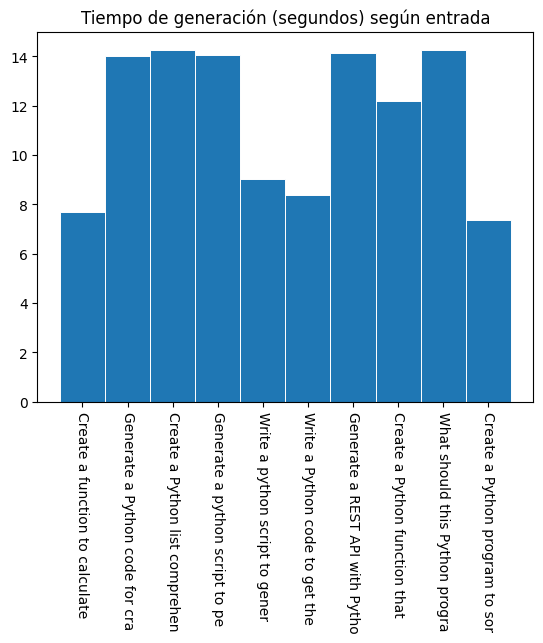

In [52]:
fig, ax = plt.subplots()
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
plt.xticks(rotation=-90)
plt.title("Tiempo de generación (segundos) según entrada")
plt.show()

In [50]:
print(f"Tiempo medio de generación: {np.mean(list(y))} segundos")

Tiempo medio de generación: 11.544975423812867 segundos


In [53]:
invalid_inputs = [
    "The stars looked brighter than ever in the clear night sky.",
    "I never thought I’d find inspiration in the simplest things.",
    "Her laughter echoed through the empty halls, filling the space with warmth.",
    "Time flies when you're doing something you love.",
    "The smell of fresh coffee in the morning is the best part of the day.",
    "Sometimes the quiet moments are the most powerful.",
    "He wandered through the forest, lost in thought.",
    "Opportunities often come disguised as challenges.",
    "The waves crashed against the shore, creating a rhythm of their own.",
    "Life is like a book, and each day is a new page waiting to be written.",
    "The sun set behind the mountains, painting the sky in shades of orange.",
    "She held the key to his heart, though she never knew it.",
    "In the silence of the night, only the crickets could be heard.",
    "He smiled as he remembered the old days, full of adventure and laughter.",
    "The rain tapped gently on the window, creating a soothing melody.",
    "Every step she took felt like a new beginning.",
    "The wind whispered secrets only the trees could understand.",
    "He always believed that there was magic in the ordinary.",
    "The city was alive with lights, yet she felt completely alone.",
    "They say patience is a virtue, but sometimes it’s a challenge.",
    "The road ahead was long, but she felt ready for the journey.",
    "His dreams were bigger than the town he was born in.",
    "She danced like no one was watching, lost in the music.",
    "The library smelled of old books and forgotten stories.",
    "Each morning brought new hope and endless possibilities.",
    "His eyes sparkled with mischief, always ready for the next adventure.",
    "The garden was in full bloom, bursting with color and life.",
    "He could hear the ocean calling, inviting him to explore its depths.",
    "The clock ticked away, but time seemed to stand still in that moment.",
    "She knew that sometimes, the smallest gestures meant the most.",
    "The world outside was cold, but the fireplace kept them warm and cozy.",
    "A single candle flickered in the dark, casting shadows on the walls.",
    "He chased his dreams like they were stars, always just out of reach.",
    "The sound of laughter filled the room, making everything feel lighter.",
    "She always saw beauty in the most unexpected places.",
    "They stood in silence, watching the sunrise together.",
    "His heart raced as he opened the letter, unsure of what it would say.",
    "The mountain loomed ahead, but he was determined to reach the top.",
    "She believed that everything happens for a reason, even if it's hard to see at first.",
    "The wind howled through the trees, making the forest feel alive.",
    "He never let fear stop him from chasing his dreams.",
    "The stars twinkled above, a reminder of how vast the universe is.",
    "She had a way of making even the ordinary feel extraordinary.",
    "The old house creaked and groaned, full of stories untold.",
    "He watched the rain fall, feeling peaceful and content.",
    "The book was old and worn, but its story was timeless.",
    "The river flowed quietly, reflecting the calmness of the day.",
    "She found solace in the simple things, like a cup of tea and a good book.",
    "The sky was a canvas, painted with clouds and sunlight.",
    "He knew that sometimes, the best adventures were the ones you didn’t plan.",
    "The waves lapped at the shore, a never-ending dance of water and sand.",
    "She felt the weight of the world lift as she took a deep breath.",
    "The forest was dense and dark, but he wasn’t afraid.",
    "She cherished the little moments, like the sound of birds in the morning.",
    "The road less traveled often leads to the most beautiful destinations.",
    "He looked out the window, lost in his thoughts.",
    "The old clock chimed, signaling the end of the day.",
    "She felt free, as if nothing in the world could hold her back.",
    "The journey of a thousand miles begins with a single step.",
    "He knew that home wasn’t a place, but a feeling."
]

In [54]:
counter = 0
for invalid_input in invalid_inputs:
    result = inference(invalid_input)
    if "ERROR" not in result:
        counter += 1

print(f"Total de entradas: {len(invalid_inputs)}")
print(f"Número de entradas inválidas no detectadas: {counter}")
print(f"Porcentaje de error: {(counter*100)/len(invalid_inputs)}")

Total de entradas: 60
Número de entradas inválidas no detectadas: 3
Porcentaje de error: 5.0


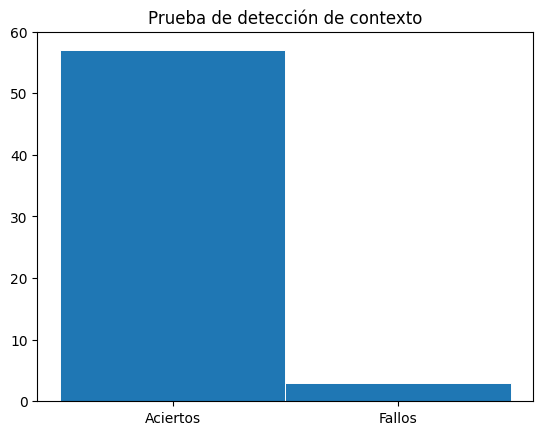

In [55]:
fig, ax = plt.subplots()
x = ["Aciertos", "Fallos"]
y = [len(invalid_inputs)-counter, counter]
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
ax.set(ylim=(0, len(invalid_inputs)))
plt.title("Prueba de detección de contexto")
plt.show()